In [1]:
# import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import optuna

# 1)
Import the fundamental data and get its basic characteristics, including shape and observation example.

In [2]:
# import data
df = pd.read_csv('调整后月频回归的面板数据.csv')
print(df.shape)
print(df.head())

(514302, 55)
   Unnamed: 0  TRADE_DT S_INFO_WINDCODE  Country  CI005001  CI005002  \
0           0  20100630       000002.SZ      1.0       0.0       0.0   
1           1  20100630       000004.SZ      1.0       0.0       0.0   
2           2  20100630       000005.SZ      1.0       0.0       0.0   
3           3  20100630       000006.SZ      1.0       0.0       0.0   
4           4  20100630       000007.SZ      1.0       0.0       0.0   

   CI005003  CI005004  CI005005  CI005006  ...  Liquidity  Long-Term Reversal  \
0       0.0       0.0       0.0       0.0  ...  -0.182327           -0.325168   
1       0.0       0.0       0.0       0.0  ...  -1.961189           -0.401099   
2       0.0       0.0       0.0       0.0  ...  -0.631946           -0.722680   
3       0.0       0.0       0.0       0.0  ...  -0.420861           -0.452365   
4       0.0       0.0       0.0       0.0  ...  -1.474335           -0.189490   

   Mid Capitalization  Momentum  Profitability  Residual Volatility

# 2)
Clean the data including:\
remove columns without information,\
remove missing values,\
change data types properly.

In [3]:
# data cleaning

# remove identical or meaningless columns (first col and 'Country')
print(df['Country'].unique())
df_0 = df.drop(columns = ['Unnamed: 0', 'Country'])
print(df_0.shape)
print(df_0.head())

# remove missing values (already no missing values)
df_0 = df_0.dropna()
print(df_0.shape)

# change data types
df_0['TRADE_DT'] = pd.to_datetime(df_0['TRADE_DT'], format='%Y%m%d')
df_0['S_INFO_WINDCODE'] = df_0['S_INFO_WINDCODE'].astype('category')
df_0[df_0.columns[2:32]] = df_0[df_0.columns[2:32]].astype("bool")
print(df_0.dtypes)

[1.]
(514302, 53)
   TRADE_DT S_INFO_WINDCODE  CI005001  CI005002  CI005003  CI005004  CI005005  \
0  20100630       000002.SZ       0.0       0.0       0.0       0.0       0.0   
1  20100630       000004.SZ       0.0       0.0       0.0       0.0       0.0   
2  20100630       000005.SZ       0.0       0.0       0.0       0.0       0.0   
3  20100630       000006.SZ       0.0       0.0       0.0       0.0       0.0   
4  20100630       000007.SZ       0.0       0.0       0.0       0.0       0.0   

   CI005006  CI005007  CI005008  ...  Liquidity  Long-Term Reversal  \
0       0.0       0.0       0.0  ...  -0.182327           -0.325168   
1       0.0       0.0       0.0  ...  -1.961189           -0.401099   
2       0.0       0.0       0.0  ...  -0.631946           -0.722680   
3       0.0       0.0       0.0  ...  -0.420861           -0.452365   
4       0.0       0.0       0.0  ...  -1.474335           -0.189490   

   Mid Capitalization  Momentum  Profitability  Residual Volatility 

# 3)
Carry out descriptive statistics for each column's features.

In [4]:
# descriptive statistics
for i in range(df_0.shape[1]):
    print(df_0[df_0.columns[i]].describe())

count                           514302
mean     2018-08-08 15:35:22.990771968
min                2010-06-30 00:00:00
25%                2015-05-29 00:00:00
50%                2019-03-29 00:00:00
75%                2021-12-31 00:00:00
max                2024-03-29 00:00:00
Name: TRADE_DT, dtype: object
count        514302
unique         5227
top       002241.SZ
freq            166
Name: S_INFO_WINDCODE, dtype: object
count     514302
unique         2
top        False
freq      507613
Name: CI005001, dtype: object
count     514302
unique         2
top        False
freq      508335
Name: CI005002, dtype: object
count     514302
unique         2
top        False
freq      499466
Name: CI005003, dtype: object
count     514302
unique         2
top        False
freq      492484
Name: CI005004, dtype: object
count     514302
unique         2
top        False
freq      506500
Name: CI005005, dtype: object
count     514302
unique         2
top        False
freq      470571
Name: CI005006, dtype:

# 4)
Split and adjust train and test datasets for application of LightGBM deep learning model.\
Here, choose monthly panel data before Jan 2024 as train data, whereas after Feb 2024 as test data.

In [ ]:
# LGB preparation

# split train and test data
d_train = df_0[df_0['TRADE_DT'] <= pd.Timestamp('2024-01-31')]
d_test = df_0[df_0['TRADE_DT'] >= pd.Timestamp('2024-02-29')]
X_train = d_train.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_train = d_train['next_Rtn']
X_test = d_test.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_test = d_test['next_Rtn']

# define LGB dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 5)
Carry out hyperparameter tuning in grid search, random search, and Bayesian optimization to get best hyperparameters as:\
"learning_rate": 0.01,\
"n_estimators": 50,\
"num_leaves": 34,\
"min_child_samples": 23,\
"max_depth": 3,\
"lambda_l1": 2.3,\
"lambda_l2": 3.5,\
"min_gain_to_split": 0,\
"feature_fraction": 0.8,\
"bagging_fraction": 0.8,\
"bagging_freq": 5.

In [ ]:
# hyperparameter tuning - grid search
param_grid = {
    "num_leaves": [15, 31, 63, 201],
    "max_depth": [-1, 3, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 500, 1000, 3000]
}

lgb_model = lgb.LGBMRegressor(boosting_type="gbdt", objective="regression")

grid_search = GridSearchCV(lgb_model, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

最佳参数:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 15}


In [ ]:
# hyperparameter tuning - random search

param_dist = {
    "num_leaves": range(20, 50, 5),
    "max_depth": [-1, 3, 7],
    "min_child_samples": range(20, 50, 5),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": range(50, 300, 50),
    "lambda_l1": [0, 1, 5],
    "lambda_l2": [0, 1, 5],
    "min_gain_to_split": [0, 0.1]
}

lgb_model = lgb.LGBMRegressor(boosting_type="gbdt", objective="regression") # device="gpu"

random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, n_iter=10, cv=3, scoring="r2", verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'num_leaves': 45, 'n_estimators': 150, 'min_gain_to_split': 0, 'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.01, 'lambda_l2': 5, 'lambda_l1': 0}
Best R² Score: -0.009640124152116717


In [ ]:
# hyperparameter tuning - Bayesian optimization

def objective(trial):
    param = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),        
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 0.1)
    }
    
    model = lgb.LGBMRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="r2").mean()
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Parameters:", study.best_params)
print("Best R² Score:", study.best_value)

[I 2025-03-26 21:41:30,197] A new study created in memory with name: no-name-e620bf2b-343b-4617-bddb-36e566cd107d
[I 2025-03-26 21:41:31,728] Trial 0 finished with value: -0.025813992977130162 and parameters: {'num_leaves': 47, 'min_child_samples': 35, 'learning_rate': 0.11907599887819983, 'n_estimators': 150, 'lambda_l1': 4.310197119066883, 'lambda_l2': 1.2212054021263108, 'min_gain_to_split': 0.09756186978223769}. Best is trial 0 with value: -0.025813992977130162.
[I 2025-03-26 21:41:33,491] Trial 1 finished with value: -0.027705453989246065 and parameters: {'num_leaves': 37, 'min_child_samples': 46, 'learning_rate': 0.19749417304004874, 'n_estimators': 300, 'lambda_l1': 5.888338698204222, 'lambda_l2': 6.7724096688297895, 'min_gain_to_split': 0.07498169629386903}. Best is trial 0 with value: -0.025813992977130162.
[I 2025-03-26 21:41:35,043] Trial 2 finished with value: -0.02452503938347017 and parameters: {'num_leaves': 30, 'min_child_samples': 39, 'learning_rate': 0.108807749942726

Best Parameters: {'num_leaves': 34, 'min_child_samples': 23, 'learning_rate': 0.010904855751363228, 'n_estimators': 50, 'lambda_l1': 2.273425765407719, 'lambda_l2': 3.53609327072088, 'min_gain_to_split': 0.008722166842491868}
Best R² Score: -0.012685924006488972


# 6)
Train the LightGBM model by setting RMSE as metric, implement prediction, and show feature importance.\
Result shows "MSE of test data: 0.0164, RMSE of test data: 0.1279, MAE of test data: 0.0841, R² of test data: 0.0020", which is not as good as WLS model.

In [6]:
# LGB model
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_estimators": 50,
    "num_leaves": 34,
    "min_child_samples": 23,
    "max_depth": 3,
    "lambda_l1": 2.3,
    "lambda_l2": 3.5,
    "min_gain_to_split": 0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
)

In [7]:
# LGB prediction and evaluation
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE of test data: {mse:.4f}")
print(f"RMSE of test data: {rmse:.4f}")
print(f"MAE of test data: {mae:.4f}")
print(f"R² of test data: {r2:.4f}")

MSE of test data: 0.0164
RMSE of test data: 0.1279
MAE of test data: 0.0841
R² of test data: 0.0020


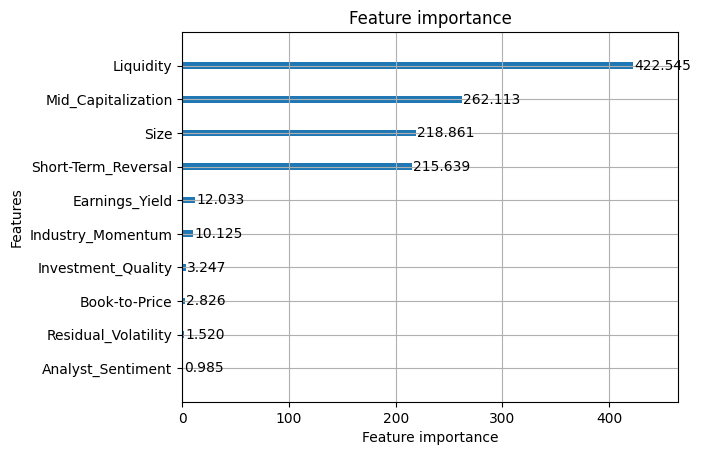

In [8]:
# LGB feature importance
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.show()

# 7) Efforts to Improve Goodness
Adjustment methods that doesn't work: \
1\) remove industry bool variables;\
2\) remove early observations;\
3\) remove COVID years' observations;\
4\) shorter term predictions.

Explanation of the phenomenon:\
Linear regression of the training dataset is inherently weak, so in this case LightGBM doesn't help much.

In [ ]:
# adjust columns - delete CI cols, no improvement
X_train = d_train.drop(d_train.columns[list(range(32)) + [52]], axis=1)
y_train = d_train['next_Rtn']
X_test = d_test.drop(d_train.columns[list(range(32)) + [52]], axis=1)
y_test = d_test['next_Rtn']
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_estimators": 50,
    "num_leaves": 34,
    "min_child_samples": 23,
    "max_depth": 3,
    "lambda_l1": 2.3,
    "lambda_l2": 3.5,
    "min_gain_to_split": 0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE of test data: {mse:.4f}")
print(f"RMSE of test data: {rmse:.4f}")
print(f"MAE of test data: {mae:.4f}")
print(f"R² of test data: {r2:.4f}")

MSE of test data: 0.0164
RMSE of test data: 0.1279
MAE of test data: 0.0841
R² of test data: 0.0019


In [ ]:
# adjust rows - delete early rows, no improvement
df_0 = df_0.loc[df_0['TRADE_DT'] >= pd.Timestamp('2015-01-01')]
d_train = df_0[(df_0['TRADE_DT'] != pd.Timestamp('2024-02-29')) & (df_0['TRADE_DT'] != pd.Timestamp('2024-03-29'))]
d_test = df_0[(df_0['TRADE_DT'] == pd.Timestamp('2024-02-29')) | (df_0['TRADE_DT'] == pd.Timestamp('2024-03-29'))]
X_train = d_train.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_train = d_train['next_Rtn']
X_test = d_test.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_test = d_test['next_Rtn']
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_estimators": 50,
    "num_leaves": 34,
    "min_child_samples": 23,
    "max_depth": 3,
    "lambda_l1": 2.3,
    "lambda_l2": 3.5,
    "min_gain_to_split": 0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE of test data: {mse:.4f}")
print(f"RMSE of test data: {rmse:.4f}")
print(f"MAE of test data: {mae:.4f}")
print(f"R² of test data: {r2:.4f}")

MSE of test data: 0.0164
RMSE of test data: 0.1280
MAE of test data: 0.0840
R² of test data: -0.0003


In [ ]:
# train / test - remove covid years
d_train1 = df_0[(df_0['TRADE_DT'] <= pd.Timestamp('2019-12-31')) | (df_0['TRADE_DT'] >= pd.Timestamp('2023-02-28'))]
d_train1 = d_train1[d_train1['TRADE_DT'] <= pd.Timestamp('2024-01-31')]
d_test1 = df_0[df_0['TRADE_DT'] >= pd.Timestamp('2024-02-29')]
X_train1 = d_train1.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_train1 = d_train1['next_Rtn']
X_test1 = d_test1.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_test1 = d_test1['next_Rtn']
train_data1 = lgb.Dataset(X_train1, label=y_train1)
test_data1 = lgb.Dataset(X_test1, label=y_test1, reference=train_data1)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_estimators": 50,
    "num_leaves": 34,
    "min_child_samples": 23,
    "max_depth": 3,
    "lambda_l1": 2.3,
    "lambda_l2": 3.5,
    "min_gain_to_split": 0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data1,
    valid_sets=[test_data1],
    num_boost_round=1000,
)
y_pred1 = model.predict(X_test1)

mse = mean_squared_error(y_test1, y_pred1)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test1, y_pred1)
r2 = r2_score(y_test1, y_pred1)
print(f"MSE of test data: {mse:.4f}")
print(f"RMSE of test data: {rmse:.4f}")
print(f"MAE of test data: {mae:.4f}")
print(f"R² of test data: {r2:.4f}")

MSE of test data: 0.0164
RMSE of test data: 0.1281
MAE of test data: 0.0841
R² of test data: -0.0008


In [ ]:
# train / test - short term
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "n_estimators": 50,
    "num_leaves": 34,
    "min_child_samples": 23,
    "max_depth": 3,
    "lambda_l1": 2.3,
    "lambda_l2": 3.5,
    "min_gain_to_split": 0,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

i_range = [4793, 24812, 87629, 150025, 350514, 387216, 500000] # randomly selected indices for testing
for i in i_range:
    d_train = df_0.iloc[i:i+50]
    d_test = df_0.iloc[i:i+50]
    X_train = d_train.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
    y_train = d_train['next_Rtn']
    X_test = d_test.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
    y_test = d_test['next_Rtn']
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        num_boost_round=1000,
        )
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE of test data: {mse:.4f}")
    print(f"RMSE of test data: {rmse:.4f}")
    print(f"MAE of test data: {mae:.4f}")
    print(f"R² of test data: {r2:.4f}")


MSE of test data: 0.0070
RMSE of test data: 0.0835
MAE of test data: 0.0675
R² of test data: 0.0000
MSE of test data: 0.0037
RMSE of test data: 0.0609
MAE of test data: 0.0448
R² of test data: 0.0000
MSE of test data: 0.0047
RMSE of test data: 0.0688
MAE of test data: 0.0511
R² of test data: -0.0000
MSE of test data: 0.0087
RMSE of test data: 0.0931
MAE of test data: 0.0697
R² of test data: 0.0000
MSE of test data: 0.0083
RMSE of test data: 0.0913
MAE of test data: 0.0665
R² of test data: 0.0000
MSE of test data: 0.0144
RMSE of test data: 0.1202
MAE of test data: 0.0714
R² of test data: -0.0000
MSE of test data: 0.0130
RMSE of test data: 0.1140
MAE of test data: 0.0970
R² of test data: -0.0000


In [ ]:
# simple linear regression
d_train = df_0[df_0['TRADE_DT'] <= pd.Timestamp('2024-01-31')]
d_test = df_0[df_0['TRADE_DT'] >= pd.Timestamp('2024-02-29')]
X_train = d_train.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_train = d_train['next_Rtn']
X_test = d_test.drop(columns = ['TRADE_DT', 'S_INFO_WINDCODE', 'next_Rtn'])
y_test = d_test['next_Rtn']

model = LinearRegression()
model.fit(X_test, y_test) #set the model to the test data
print("Intercept (b):", model.intercept_)
print("Slope (m):", model.coef_)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Intercept (b): 0.0032905977704809214
Slope (m): [ 0.01679058 -0.02475006  0.0622467   0.01711122 -0.0023322   0.02920894
 -0.01894658 -0.02717794  0.01856108  0.00860834  0.00165043  0.0248708
  0.03022872 -0.01378787 -0.00381508  0.04838846 -0.00252816  0.00097787
  0.00999743 -0.01041737  0.00034238 -0.02917312 -0.02296291  0.00909171
  0.00183112  0.00632646 -0.0075984  -0.01723421 -0.05321203 -0.0522963
 -0.00159894 -0.00014939  0.00587781 -0.00355009 -0.00010452 -0.0029287
 -0.00068008 -0.00141963 -0.00082004  0.00079887 -0.00049313 -0.00596604
  0.00066451 -0.00181838 -0.00159435  0.00355442  0.00383656 -0.00036226
 -0.00575098 -0.00197295]
Mean Squared Error (MSE): 0.01590149893571767
R² Score: 0.029710461882718975
